In [619]:
import cmdstanpy
import pandas as pd
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scipy.stats as stats

MODEL_PATH = 'max_model.stan'
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [640]:
temps = pd.read_csv('data/Hyperlocal_Temperature_Monitoring.csv')
temps.head()

,Sensor.ID,AirTemp,Day,Hour,Latitude,Longitude,Year,Install.Type,Borough,ntacode
0,Bk-BR_01,71.189000,06/15/2018,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
1,Bk-BR_01,70.243333,06/15/2018,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
2,Bk-BR_01,69.392667,06/15/2018,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
3,Bk-BR_01,68.263167,06/15/2018,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81
4,Bk-BR_01,67.114000,06/15/2018,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81


In [641]:
covariates = pd.read_csv('data/temp3.csv').round(8)
covariates2 = pd.read_csv('data/temp_1.csv').round(8)
covariates = covariates.merge(covariates2)
covariates['mean_fa_ratio'] = covariates['mean_fa_ratio'].fillna(0)
temps = temps.drop(index=np.where(temps['AirTemp'].isna())[0]).reset_index(0)
temps = temps.groupby(['Latitude','Longitude','Day','Year']).agg({'AirTemp':np.max}).reset_index(0).reset_index(0).reset_index(0).reset_index(0)
data = temps.merge(covariates, how='outer', on=['Latitude','Longitude'])

In [499]:
N = data.shape[0]
X_new_size = 5000
X_size = N - X_new_size
shuffled_data = data.sample(frac=1)

In [500]:
d = {'N': N, 'M': X_size}

for col in shuffled_data.columns:
    if col not in ['Day','Year','Latitude','Longitude','AirTemp']:
        d[col] = shuffled_data[col].values

d['y'] = shuffled_data['AirTemp'].values
r = json.dumps(d,cls=NpEncoder)
with open('data/data.json', 'w') as f:
    json.dump(json.loads(r), f)

In [501]:
DATA = 'data/data.json'

In [613]:
model = CmdStanModel(stan_file=MODEL_PATH)

INFO:cmdstanpy:compiling stan program, exe file: /Users/sotiriskaragounis/git/UHInyc/max_model
INFO:cmdstanpy:compiler options: stanc_options={}, cpp_options={}
INFO:cmdstanpy:compiled model file: /Users/sotiriskaragounis/git/UHInyc/max_model


In [514]:
bern_vb = model.variational(data=d,require_converged=False)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
Proceeding because require_converged is set to False


## MCMC

In [614]:
mle = model.sample(data=d)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1


In [ ]:
sns.distplot(result)
sns.distplot(test['AirTemp'])

In [517]:
list(bern_vb.variational_params_dict.items())[:10]

[('lp__', 0.0),
 ('log_p__', 0.0),
 ('log_g__', 0.0),
 ('a', -0.171194),
 ('b', 14.7905),
 ('c', 0.00567869),
 ('d', 2.34518),
 ('bias', 65.7913),
 ('sigma', 85.6991),
 ('log_p', -441575.0)]

In [615]:
y_sims = mle.stan_variable(var='y_rep')

In [616]:
def check(simulated_data,y,agg_func,function_name):
    agg_data = agg_func(simulated_data,axis=1)
    ax = sns.displot(agg_data)
    ax.fig.suptitle(function_name)
    ax.axes[0][0].axvline(x = agg_func(y), color='red', linewidth=1,label='Original Data')
    plt.legend()
    plt.show()

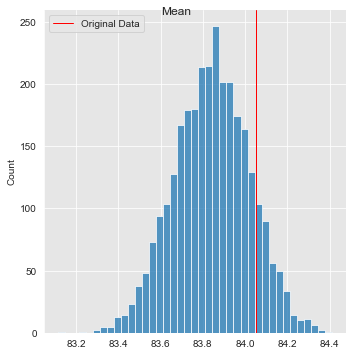

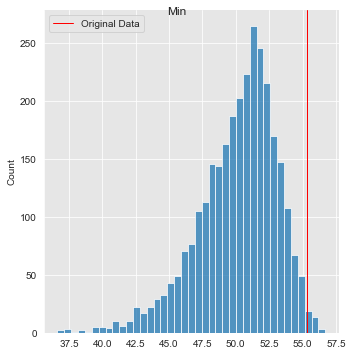

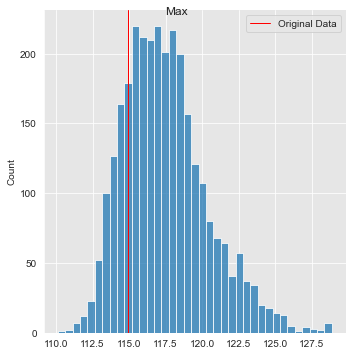

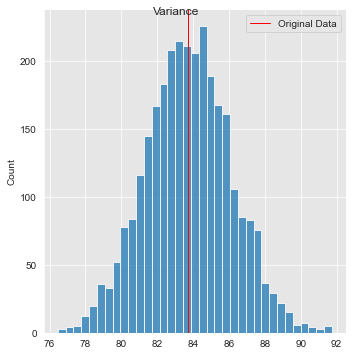

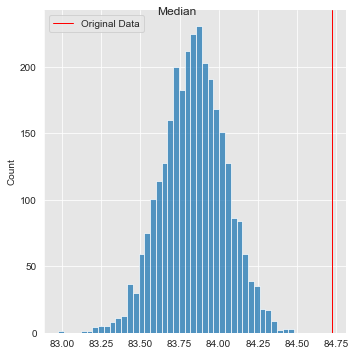

In [617]:
n = 3000
y = shuffled_data['AirTemp'][:X_size] 
simulated_data = y_sims[:n]

check(simulated_data,y,np.mean,'Mean')
check(simulated_data,y,np.min,'Min')
check(simulated_data,y,np.max,'Max')
check(simulated_data,y,np.var,'Variance')
check(simulated_data,y,np.median,'Median')